<a href="https://colab.research.google.com/github/HoudCa/tagspred/blob/main/Dog.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Aller sur l'onglet "Exécution" puis "modifier type d'exécution". Sélectionner GPU

In [7]:
import tensorflow as tf
tf.test.gpu_device_name()

2022-06-20 08:51:47.001526: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


''

In [8]:
!pip install mat4py

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [9]:
!pip install keras-tuner --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [10]:
!pip install tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [11]:
import copy
import pandas as pd
import numpy as np
import random
import tensorboard
from mat4py import loadmat
from IPython.display import Image
import datetime
from PIL import Image
import plotly.express as px
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, InceptionV3
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import img_to_array, load_img
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_v3 import preprocess_input
import tensorflow_addons as tfa
from tensorflow.python.summary.summary_iterator import summary_iterator
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils import shuffle
import keras_tuner as kt
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [12]:
# Clear any logs from previous runs
! rm -rf cnn_log
! rm -rf vgg_log
! rm -rf inception_log
! rm -rf inception_120_log
! rm -rf untitled_project
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [13]:
seed = 999
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

# Preparing Datasets

In [14]:
# Load meta data
train_df_init = pd.DataFrame(loadmat('/content/train_list.mat'))
test_df_init = pd.DataFrame(loadmat('/content/test_list.mat'))
train_df_init.shape, test_df_init.shape

((12000, 3), (8580, 3))

In [15]:
train_df_init = train_df_init.applymap(lambda x: x[0])
test_df_init = test_df_init.applymap(lambda x: x[0])

In [ ]:
train_df_init.head()

,file_list,annotation_list,labels
0,n02085620-Chihuahua/n02085620_5927.jpg,n02085620-Chihuahua/n02085620_5927,1
1,n02085620-Chihuahua/n02085620_4441.jpg,n02085620-Chihuahua/n02085620_4441,1
2,n02085620-Chihuahua/n02085620_1502.jpg,n02085620-Chihuahua/n02085620_1502,1
3,n02085620-Chihuahua/n02085620_1916.jpg,n02085620-Chihuahua/n02085620_1916,1
4,n02085620-Chihuahua/n02085620_13151.jpg,n02085620-Chihuahua/n02085620_13151,1


In [18]:
train_df_init['label'] = train_df_init['file_list'].apply(lambda x: x.split('/')[0].split('-')[1].replace('_', ' ').capitalize())
test_df_init['label'] = test_df_init['file_list'].apply(lambda x: x.split('/')[0].split('-')[1].replace('_', ' ').capitalize())

In [22]:
train_df_init.head()

,file_list,annotation_list,labels,label
0,n02085620-Chihuahua/n02085620_5927.jpg,n02085620-Chihuahua/n02085620_5927,1,Chihuahua
1,n02085620-Chihuahua/n02085620_4441.jpg,n02085620-Chihuahua/n02085620_4441,1,Chihuahua
2,n02085620-Chihuahua/n02085620_1502.jpg,n02085620-Chihuahua/n02085620_1502,1,Chihuahua
3,n02085620-Chihuahua/n02085620_1916.jpg,n02085620-Chihuahua/n02085620_1916,1,Chihuahua
4,n02085620-Chihuahua/n02085620_13151.jpg,n02085620-Chihuahua/n02085620_13151,1,Chihuahua


In [ ]:
trained_dataset = train_df_init.groupby(['label']).agg(
    Count=('label', len))
trained_dataset.reset_index(inplace=True)
trained_dataset.head()

,label,Count
0,Affenpinscher,100
1,Afghan hound,100
2,African hunting dog,100
3,Airedale,100
4,American staffordshire terrier,100


In [ ]:
fig = px.bar(trained_dataset, x='label', y='Count', color='label', title='Trained dataset Composition', height=750)
fig.show()

In [19]:
# Extract first n labels
nb_classes = 3

def get_n_classes(train_df, test_df, n_classes):

    train_df = shuffle(train_df[train_df['labels'] <= n_classes])
    test_df = shuffle(test_df[test_df['labels'] <= n_classes])

    return train_df, test_df


# We apply the g_n_classes
train_df, test_df = get_n_classes(train_df_init, test_df_init, nb_classes)
train_df.shape, test_df.shape

((300, 4), (289, 4))

In [20]:
from google.colab import drive 
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [21]:
images_path = '/content/drive/MyDrive/Colab Notebooks/Images/'

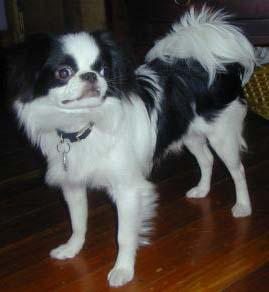

In [24]:
def get_sample(df):
    # Get a random sample
    sample = df.sample(1)
    sample_path = images_path + sample['file_list'].values[0]
    sample_img = Image.open(sample_path)

    return sample, sample_img, sample_path

sample, sample_img, sample_path = get_sample(train_df)
sample_img

# Image Data Augmentation and Data pre-processing 

In [22]:
def show_transformations(sample_path, datagen_settings, n_examples=3):

    sim_generator = ImageDataGenerator(**datagen_settings)

    img = load_img(sample_path) # img: PIL Image instance
    x = img_to_array(img)  # a Numpy array
    x = np.expand_dims(x, axis=0) # add a new dimension
    #x.reshape((1,) + x.shape)  
    fig = plt.figure(figsize=(25,25))
    plt.subplot(1,4,1)
    plt.title('Original')
    plt.imshow(img)
    plt.axis('off')

    sim_generator.fit(x)
    
    i = 0
    for img in sim_generator.flow(x, batch_size=1):
        plt.subplot(1,4,i+2)
        plt.title(f'Augmented')
        plt.imshow(img[0])
        plt.axis('off')
        i += 1
        if i == n_examples :
            break

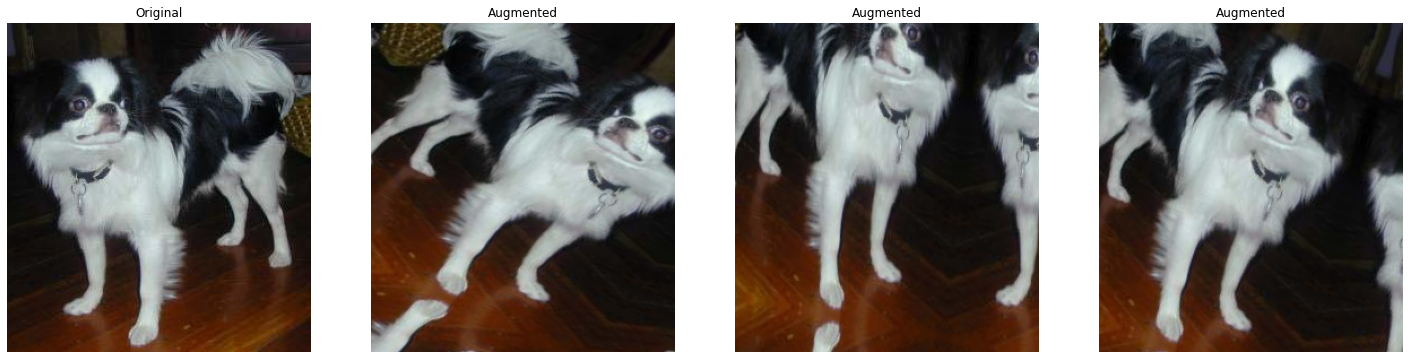

In [26]:
augmentation_settings = dict(
        rescale=1./255.,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='reflect')

show_transformations(
    sample_path=sample_path,
    datagen_settings=augmentation_settings)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


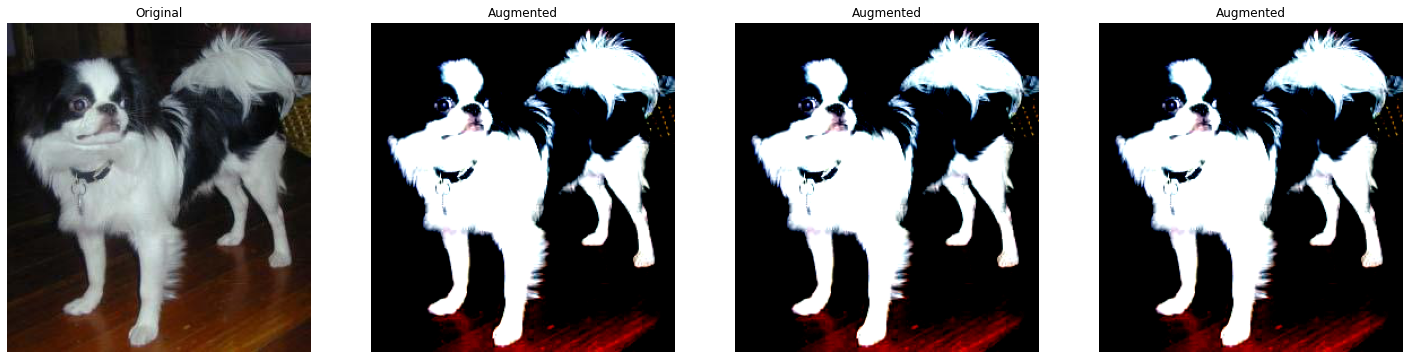

In [27]:
processing_settings = dict(
        rescale=1./255.,
        featurewise_center=True,
        featurewise_std_normalization=True)

show_transformations(
    sample_path=sample_path,
    datagen_settings=processing_settings,
    n_examples=3)

In [ ]:
class FixedImageDataGenerator(ImageDataGenerator):
    def standardize(self, x):
        if self.featurewise_center:
            x = ((x/255.) - 0.5) * 2.
        return x

In [ ]:
datagen_settings = {**processing_settings, **augmentation_settings

In [ ]:
print(datagen_settings)

{'rescale': 0.00392156862745098, 'featurewise_center': True, 'featurewise_std_normalization': True, 'rotation_range': 40, 'width_shift_range': 0.2, 'height_shift_range': 0.2, 'shear_range': 0.2, 'zoom_range': 0.2, 'horizontal_flip': True, 'fill_mode': 'reflect'}


In [ ]:
train_datagen = FixedImageDataGenerator(**datagen_settings)
test_datagen = ImageDataGenerator(rescale=1./255.)

# CNN Transfert Learning with VGG-16 

## Use of VGG16 fuction preprocessing

In [23]:
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg16_pr

train_datagen = ImageDataGenerator(preprocessing_function=vgg16_pr)
test_datagen = ImageDataGenerator(preprocessing_function=vgg16_pr)

In [24]:
target_size = (224,224)
batch_size = 64
generator_settings = dict(
    directory=images_path,
    x_col='file_list',
    y_col='label',
    class_mode='categorical',
    target_size=target_size,
    batch_size=batch_size)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    **generator_settings,
    seed=seed)
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    **generator_settings,
    seed=seed)

Found 300 validated image filenames belonging to 3 classes.
Found 289 validated image filenames belonging to 3 classes.


In [25]:
def gen_generators(train_df, test_df, n_classes=3, batch_size=batch_size):    

    train_df, test_df = get_n_classes(train_df_init, test_df_init, n_classes)
    # Set labels dtype for the generator
    train_df['labels'] = train_df['labels'].astype(str)
    test_df['labels'] = test_df['labels'].astype(str)
    
    train_datagen = ImageDataGenerator(preprocessing_function=vgg16_pr)
    test_datagen = ImageDataGenerator(preprocessing_function=vgg16_pr)
    
    train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_df,
        **generator_settings,
        seed=seed)
    test_generator = test_datagen.flow_from_dataframe(
        dataframe=test_df,
        **generator_settings,
        seed=seed)

    steps_per_epoch = train_df.shape[0] // batch_size
    validation_steps = test_df.shape[0] // batch_size

    return train_generator, test_generator, steps_per_epoch, validation_steps

In [26]:
train_generator, test_generator, steps_per_epoch, validation_steps = gen_generators(train_df_init, test_df_init, nb_classes)

Found 300 validated image filenames belonging to 3 classes.
Found 289 validated image filenames belonging to 3 classes.


In [27]:
model_base_vgg = VGG16(
    weights="imagenet",
    include_top=False, 
    input_shape=train_generator.image_shape)
model_base_vgg.trainable = False
model_base_vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [28]:
from tensorflow import keras
opt = keras.optimizers.Adam(learning_rate=0.01)
# Flatten the output layer to 1 dimension
xx = layers.Flatten()(model_base_vgg.output)

# Add a fully connected layer with 512 hidden units and ReLU activation
xx = layers.Dense(512, activation='relu')(xx)

# Add a dropout rate of 0.5
xx = layers.Dropout(0.5)(xx)

# Add a final sigmoid layer with 1 node for classification output
xx = layers.Dense(3, activation='softmax')(xx)

model = tf.keras.models.Model(model_base_vgg.input, xx)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

### Compile model

In [29]:
model.compile(optimizer = opt, loss = 'categorical_crossentropy', metrics = ['acc'])

### Fit the model

#### Checkpointing with an improvement in classification accuracy on the validation dataset and EarlyStopping

In [26]:
from tensorflow.keras.callbacks import ModelCheckpoint
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(
        patience=30),
    tf.keras.callbacks.ModelCheckpoint(
        filepath='CNN-VGG16-{epoch:02d}-{val_acc:.2f}.hdf5',
        monitor='val_acc',
        verbose=1,
        mode='max',
        save_weights_only=True,
        save_best_only=True),
]

In [27]:
vgg_hist = model.fit(
    train_generator,
    epochs=10,
    validation_data=test_generator,
    steps_per_epoch=4,
    callbacks=my_callbacks)

Epoch 1/10
4/4 [==============================] - ETA: 0s - loss: 524.1913 - acc: 0.5593 
Epoch 1: val_acc improved from -inf to 0.89965, saving model to CNN-VGG16-01-0.90.hdf5
4/4 [==============================] - 288s 78s/step - loss: 524.1913 - acc: 0.5593 - val_loss: 142.2473 - val_acc: 0.8997
Epoch 2/10
4/4 [==============================] - ETA: 0s - loss: 173.3423 - acc: 0.8771 
Epoch 2: val_acc improved from 0.89965 to 0.97578, saving model to CNN-VGG16-02-0.98.hdf5
4/4 [==============================] - 240s 70s/step - loss: 173.3423 - acc: 0.8771 - val_loss: 22.5906 - val_acc: 0.9758
Epoch 3/10
4/4 [==============================] - ETA: 0s - loss: 16.5069 - acc: 0.9788 
Epoch 3: val_acc did not improve from 0.97578
4/4 [==============================] - 261s 79s/step - loss: 16.5069 - acc: 0.9788 - val_loss: 35.4760 - val_acc: 0.9723
Epoch 4/10
4/4 [==============================] - ETA: 0s - loss: 20.7867 - acc: 0.9746 
Epoch 4: val_acc improved from 0.97578 to 0.98270, sa

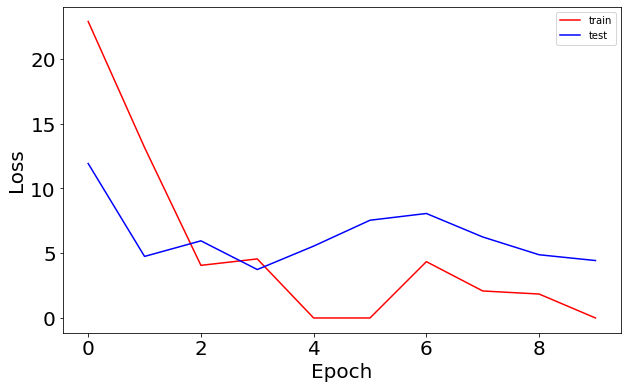

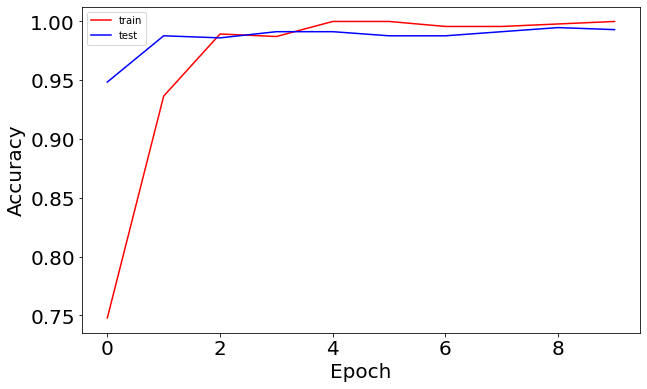

In [28]:
import matplotlib.pyplot as plt
# Plot the loss function
fig, ax = plt.subplots(1, 1, figsize=(10,6))
ax.plot(np.sqrt(vgg_hist.history['loss']), 'r', label='train')
ax.plot(np.sqrt(vgg_hist.history['val_loss']), 'b' ,label='test')
ax.set_xlabel(r'Epoch', fontsize=20)
ax.set_ylabel(r'Loss', fontsize=20)
ax.legend()
ax.tick_params(labelsize=20)

# Plot the accuracy
fig, ax = plt.subplots(1, 1, figsize=(10,6))
ax.plot(np.sqrt(vgg_hist.history['acc']), 'r', label='train')
ax.plot(np.sqrt(vgg_hist.history['val_acc']), 'b' ,label='test')
ax.set_xlabel(r'Epoch', fontsize=20)
ax.set_ylabel(r'Accuracy', fontsize=20)
ax.legend()
ax.tick_params(labelsize=20)

In [29]:
# à changer 
from google.colab import files
files.download("CNN-VGG16-09-0.99.hdf5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [30]:
# Load the Model with the Best Validation accuracy
model.load_weights('CNN-VGG16-09-0.99.hdf5')

In [31]:
pred = model.predict(test_generator, verbose=1)
predicted_class_indices = np.argmax(pred,axis=1)

5/5 [==============================] - 147s 28s/step


In [32]:
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]

In [49]:
filenames = test_generator.filenames
results = pd.DataFrame({"Filename":filenames,"Predictions":predictions})

results['True_label'] = results['Filename'].apply(lambda x: x.split('/')[0].split('-')[1].replace('_', ' ').capitalize())
results.to_csv("results.csv",index=False)
results

,Filename,Predictions,True_label
0,n02085936-Maltese_dog/n02085936_1247.jpg,Chihuahua,Maltese dog
1,n02085936-Maltese_dog/n02085936_548.jpg,Japanese spaniel,Maltese dog
2,n02085620-Chihuahua/n02085620_6399.jpg,Chihuahua,Chihuahua
3,n02085620-Chihuahua/n02085620_1271.jpg,Japanese spaniel,Chihuahua
4,n02085936-Maltese_dog/n02085936_6077.jpg,Japanese spaniel,Maltese dog
...,...,...,...
284,n02085782-Japanese_spaniel/n02085782_3810.jpg,Japanese spaniel,Japanese spaniel
285,n02085936-Maltese_dog/n02085936_4396.jpg,Maltese dog,Maltese dog
286,n02085620-Chihuahua/n02085620_3409.jpg,Maltese dog,Chihuahua
287,n02085936-Maltese_dog/n02085936_9367.jpg,Maltese dog,Maltese dog


# Personel CNN from Scratch

In [51]:
#from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import Dropout, Flatten, Dense
from tensorflow.keras.callbacks import ModelCheckpoint
import pandas as pd

In [53]:
def PersoModel_seq_fct(ker_size, drop_level, activ_hidden='relu', activ_final='softmax'):
  model = Sequential()
  model.add(Conv2D(16, ker_size, strides = (1, 1), activation=activ_hidden, input_shape=(224,224,3)))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(drop_level))
  model.add(Conv2D(32, ker_size, strides = (1, 1), activation=activ_hidden))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(drop_level))
  model.add(Conv2D(64, ker_size, strides = (1, 1), activation=activ_hidden))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(drop_level))
  model.add(Conv2D(128, ker_size, strides = (1, 1), activation=activ_hidden))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(drop_level)) 
  model.add(Conv2D(256, ker_size, strides = (1, 1), activation=activ_hidden))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(drop_level)) 
  # model.add(Flatten())
  model.add(GlobalAveragePooling2D())
  model.add(Dense(256, activation=activ_hidden))
  model.add(Dropout(drop_level))
  model.add(Dense(3, activation=activ_final))
  return model

## Tuning Hyperparameters

In [55]:
# Define parameter possibilities as lists
ks = [3,4]
do = [0.25,0.5]
lr = [1e-2,1e-3]
bz = [4,16]

tab = []
# Nested loops - we need to test for all combinations
for k in ks:
    for d in do:
      for l in lr:
        for b in bz:
          def gen_generators(train_df, test_df, n_classes=3, batch_size=batch_size):
            train_df, test_df = get_n_classes(train_df_init, test_df_init, n_classes)
            # Set labels dtype for the generator
            train_df['labels'] = train_df['labels'].astype(str)
            test_df['labels'] = test_df['labels'].astype(str)
            train_datagen = ImageDataGenerator(preprocessing_function=vgg16_pr)
            test_datagen = ImageDataGenerator(preprocessing_function=vgg16_pr)
            train_generator = train_datagen.flow_from_dataframe(
                dataframe=train_df,
                **generator_settings,
                seed=seed)
            test_generator = test_datagen.flow_from_dataframe(
                dataframe=test_df,
                **generator_settings,
                seed=seed)
            steps_per_epoch = train_df.shape[0] // batch_size
            validation_steps = test_df.shape[0] // batch_size
            return train_generator, test_generator, steps_per_epoch, validation_steps
          train_generator, test_generator, steps_per_epoch, validation_steps = gen_generators(train_df_init,
                                                                                              test_df_init,
                                                                                              n_classes=3,
                                                                                              batch_size=b)
          # Compile the model
          model = PersoModel_seq_fct(ker_size=(k,k),
                                     drop_level = d,
                                     activ_hidden='relu',
                                     activ_final='softmax')
  
            
          opt = keras.optimizers.Adam(learning_rate=l)
          model.compile(optimizer=opt,
                          loss='categorical_crossentropy',
                          metrics=['acc'])
            
            

          #train the model
          checkpointer = [tf.keras.callbacks.EarlyStopping(patience=35),
                            tf.keras.callbacks.ModelCheckpoint(
                                filepath='myCNN-loop-{epoch:02d}-{val_acc:.2f}.hdf5',
                                monitor='val_acc',
                                verbose=1,
                                mode='max',
                                save_weights_only=True,
                                save_best_only=True),
                            ]
            
          cnn_history = model.fit(train_generator,
                      epochs=10,
                      validation_data=test_generator,
                      steps_per_epoch=4,
                      batch_size=b,
                      callbacks=[checkpointer],
                      verbose=1)
          
          val_loss = round(max(cnn_history.history['val_loss']),2)
          val_accu = round(max(cnn_history.history['val_acc']),2)
          tab.append([k, d, l, b, val_loss, val_accu])

df = pd.DataFrame(tab, columns = ["Kernel_size", "Drop_level",
                                  "learning_rate", "Batch_size", "Val_loss", "Val_accuracy"])
df           

Found 300 validated image filenames belonging to 3 classes.
Found 289 validated image filenames belonging to 3 classes.
Epoch 1/10
4/4 [==============================] - ETA: 0s - loss: 767.7820 - acc: 0.3347 
Epoch 1: val_acc improved from -inf to 0.18685, saving model to myCNN-loop-01-0.19.hdf5
4/4 [==============================] - 20s 5s/step - loss: 767.7820 - acc: 0.3347 - val_loss: 1.1145 - val_acc: 0.1869
Epoch 2/10
4/4 [==============================] - ETA: 0s - loss: 1.2292 - acc: 0.3602
Epoch 2: val_acc did not improve from 0.18685
4/4 [==============================] - 17s 5s/step - loss: 1.2292 - acc: 0.3602 - val_loss: 1.1005 - val_acc: 0.1799
Epoch 3/10
4/4 [==============================] - ETA: 0s - loss: 1.1025 - acc: 0.3281
Epoch 3: val_acc improved from 0.18685 to 0.52595, saving model to myCNN-loop-03-0.53.hdf5
4/4 [==============================] - 18s 5s/step - loss: 1.1025 - acc: 0.3281 - val_loss: 1.0913 - val_acc: 0.5260
Epoch 4/10
4/4 [======================

,Kernel_size,Drop_level,learning_rate,Batch_size,Val_loss,Val_accuracy
0,3,0.25,0.010,4,1.11,0.53
1,3,0.25,0.010,16,1.15,0.53
2,3,0.25,0.001,4,1.68,0.54
3,3,0.25,0.001,16,1.41,0.54
4,3,0.50,0.010,4,1.13,0.53
5,3,0.50,0.010,16,1.15,0.52
6,3,0.50,0.001,4,2.96,0.53
7,3,0.50,0.001,16,1.84,0.53
8,4,0.25,0.010,4,1.11,0.48
9,4,0.25,0.010,16,1.34,0.53


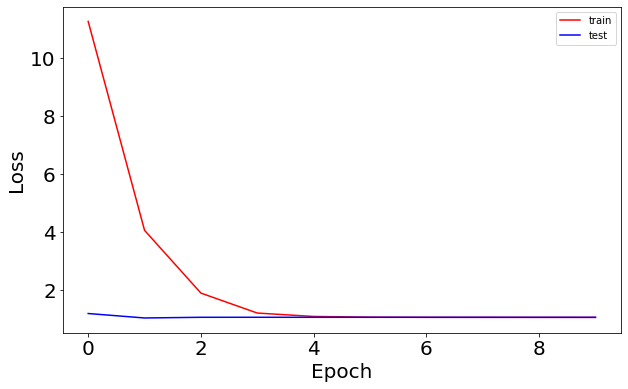

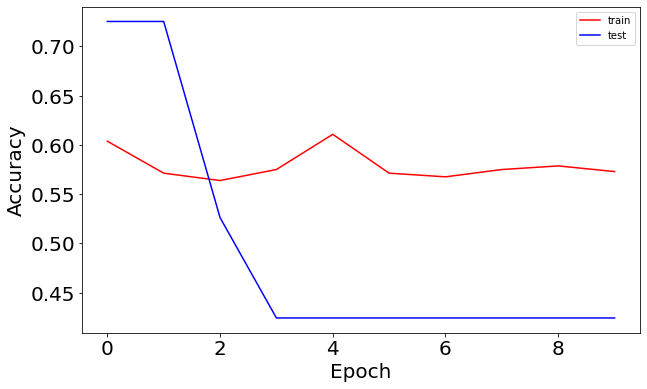

In [56]:
# Plot the loss function
fig, ax = plt.subplots(1, 1, figsize=(10,6))
ax.plot(np.sqrt(cnn_history.history['loss']), 'r', label='train')
ax.plot(np.sqrt(cnn_history.history['val_loss']), 'b' ,label='test')
ax.set_xlabel(r'Epoch', fontsize=20)
ax.set_ylabel(r'Loss', fontsize=20)
ax.legend()
ax.tick_params(labelsize=20)

# Plot the accuracy
fig, ax = plt.subplots(1, 1, figsize=(10,6))
ax.plot(np.sqrt(cnn_history.history['acc']), 'r', label='train')
ax.plot(np.sqrt(cnn_history.history['val_acc']), 'b' ,label='test')
ax.set_xlabel(r'Epoch', fontsize=20)
ax.set_ylabel(r'Accuracy', fontsize=20)
ax.legend()
ax.tick_params(labelsize=20)

In [57]:
from google.colab import files
files.download("myCNN-loop-09-0.54.hdf5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [58]:
model.load_weights('myCNN-loop-09-0.54.hdf5')

In [59]:
pred_1 = model.predict(test_generator, verbose=1)
predicted_class_indices_1 = np.argmax(pred_1, axis=1)

5/5 [==============================] - 6s 975ms/step


In [60]:
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions_1 = [labels[k] for k in predicted_class_indices_1]

In [61]:
filenames = test_generator.filenames
results_1 = pd.DataFrame({"Filename":filenames,"Predictions":predictions_1})

results_1['True_label'] = results_1['Filename'].apply(lambda x: x.split('/')[0].split('-')[1].replace('_', ' ').capitalize())
results_1.to_csv("results.csv",index=False)
results_1

,Filename,Predictions,True_label
0,n02085936-Maltese_dog/n02085936_9136.jpg,Maltese dog,Maltese dog
1,n02085936-Maltese_dog/n02085936_1515.jpg,Maltese dog,Maltese dog
2,n02085620-Chihuahua/n02085620_12718.jpg,Maltese dog,Chihuahua
3,n02085620-Chihuahua/n02085620_4602.jpg,Maltese dog,Chihuahua
4,n02085620-Chihuahua/n02085620_6931.jpg,Maltese dog,Chihuahua
...,...,...,...
284,n02085936-Maltese_dog/n02085936_4343.jpg,Maltese dog,Maltese dog
285,n02085936-Maltese_dog/n02085936_10130.jpg,Maltese dog,Maltese dog
286,n02085782-Japanese_spaniel/n02085782_810.jpg,Maltese dog,Japanese spaniel
287,n02085782-Japanese_spaniel/n02085782_309.jpg,Maltese dog,Japanese spaniel


# Testing with a specific image and best model

Save the best model with h5 extension

In [31]:
from tensorflow.keras.callbacks import ModelCheckpoint
my_callbacks = [
    keras.callbacks.EarlyStopping(
        patience=30),
    keras.callbacks.ModelCheckpoint(
        filepath='model-VGG16-{epoch:02d}-{val_acc:.2f}.h5',
        monitor='val_acc',
        verbose=1,
        mode='max',
        save_weights_only=True,
        save_best_only=True),
]

In [32]:
vgg_hist = model.fit(
    train_generator,
    epochs=10,
    validation_data=test_generator,
    steps_per_epoch=4,
    callbacks=my_callbacks)

Epoch 1/10


tcmalloc: large alloc 7398981632 bytes == 0x937b0000 @  0x7f39d40f51e7 0x7f3980e1632f 0x7f398395e78a 0x7f3983dbbd24 0x7f3983e0bd1e 0x7f3983e0cfb7 0x7f3983e0dfba 0x7f3983e0fdae 0x7f3983e14102 0x7f3983e145ef 0x7f397923d2b8 0x7f39791cff33 0x7f397ec151b1 0x7f397ec11e73 0x7f39798f6515 0x7f39d3ab96db 0x7f39d3df261f
tcmalloc: large alloc 1850064896 bytes == 0x627b0000 @  0x7f39d40f51e7 0x7f3980e1632f 0x7f398395e78a 0x7f3983dbbd24 0x7f3983e0bd1e 0x7f3983e0cfb7 0x7f3983e0dfba 0x7f3983e0fdae 0x7f3983e14102 0x7f3983e145ef 0x7f397923d2b8 0x7f39791cff33 0x7f397ec151b1 0x7f397ec11e73 0x7f39798f6515 0x7f39d3ab96db 0x7f39d3df261f
tcmalloc: large alloc 1850064896 bytes == 0x627b0000 @  0x7f39d40f51e7 0x7f3980e1632f 0x7f398395e78a 0x7f3983dbbd24 0x7f3983e0bd1e 0x7f3983e0cfb7 0x7f3983e0dfba 0x7f3983e0fdae 0x7f3983e14102 0x7f3983e145ef 0x7f397923d2b8 0x7f39791cff33 0x7f397ec151b1 0x7f397ec11e73 0x7f39798f6515 0x7f39d3ab96db 0x7f39d3df261f


1/4 [======>.......................] - ETA: 1:42 - loss: 23.0244 - acc: 0.3438

tcmalloc: large alloc 5086830592 bytes == 0x842b0000 @  0x7f39d40f51e7 0x7f3980e1632f 0x7f398395e78a 0x7f3983dbbd24 0x7f3983e0bd1e 0x7f3983e0cfb7 0x7f3983e0dfba 0x7f3983e0fdae 0x7f3983e14102 0x7f3983e145ef 0x7f397923d2b8 0x7f39791cff33 0x7f397ec151b1 0x7f397ec11e73 0x7f39798f6515 0x7f39d3ab96db 0x7f39d3df261f


2/4 [==============>...............] - ETA: 39s - loss: 513.3231 - acc: 0.3148

tcmalloc: large alloc 7398981632 bytes == 0x24cfe8000 @  0x7f39d40f51e7 0x7f3980e1632f 0x7f398395e78a 0x7f3983dbbd24 0x7f3983e0bd1e 0x7f3983e0cfb7 0x7f3983e0dfba 0x7f3983e0fdae 0x7f3983e14102 0x7f3983e145ef 0x7f397923d2b8 0x7f39791cff33 0x7f397ec151b1 0x7f397ec11e73 0x7f39798f6515 0x7f39d3ab96db 0x7f39d3df261f


3/4 [=====================>........] - ETA: 25s - loss: 595.2084 - acc: 0.4128

tcmalloc: large alloc 7398981632 bytes == 0x3f884000 @  0x7f39d40f51e7 0x7f3980e1632f 0x7f398395e78a 0x7f3983dbbd24 0x7f3983e0bd1e 0x7f3983e0cfb7 0x7f3983e0dfba 0x7f3983e0fdae 0x7f3983e14102 0x7f3983e145ef 0x7f397923d2b8 0x7f39791cff33 0x7f397ec151b1 0x7f397ec11e73 0x7f39798f6515 0x7f39d3ab96db 0x7f39d3df261f


4/4 [==============================] - ETA: 0s - loss: 511.7888 - acc: 0.5127 

tcmalloc: large alloc 7398981632 bytes == 0x2fe6c000 @  0x7f39d40f51e7 0x7f3980e1632f 0x7f398395e78a 0x7f3983dbbd24 0x7f3983e0bd1e 0x7f3983e0cfb7 0x7f3983e0dfba 0x7f3983e0fdae 0x7f3983e14102 0x7f3983e145ef 0x7f397923d2b8 0x7f39791cff33 0x7f397ec151b1 0x7f397ec11e73 0x7f39798f6515 0x7f39d3ab96db 0x7f39d3df261f
tcmalloc: large alloc 7398981632 bytes == 0x2fe6c000 @  0x7f39d40f51e7 0x7f3980e1632f 0x7f398395e78a 0x7f3983dbbd24 0x7f3983e0bd1e 0x7f3983e0cfb7 0x7f3983e0dfba 0x7f3983e0fdae 0x7f3983e14102 0x7f3983e145ef 0x7f397923d2b8 0x7f39791cff33 0x7f397ec151b1 0x7f397ec11e73 0x7f39798f6515 0x7f39d3ab96db 0x7f39d3df261f
tcmalloc: large alloc 7398981632 bytes == 0x2fe6c000 @  0x7f39d40f51e7 0x7f3980e1632f 0x7f398395e78a 0x7f3983dbbd24 0x7f3983e0bd1e 0x7f3983e0cfb7 0x7f3983e0dfba 0x7f3983e0fdae 0x7f3983e14102 0x7f3983e145ef 0x7f397923d2b8 0x7f39791cff33 0x7f397ec151b1 0x7f397ec11e73 0x7f39798f6515 0x7f39d3ab96db 0x7f39d3df261f
tcmalloc: large alloc 7398981632 bytes == 0x2fe6c000 @  0x7f39d40f5


Epoch 1: val_acc improved from -inf to 0.89965, saving model to model-VGG16-01-0.90.h5
4/4 [==============================] - 247s 71s/step - loss: 511.7888 - acc: 0.5127 - val_loss: 126.6823 - val_acc: 0.8997
Epoch 2/10


tcmalloc: large alloc 7398981632 bytes == 0x1fe8e000 @  0x7f39d40f51e7 0x7f3980e1632f 0x7f398395e78a 0x7f3983dbbd24 0x7f3983e0bd1e 0x7f3983e0cfb7 0x7f3983e0dfba 0x7f3983e0fdae 0x7f3983e14102 0x7f3983e145ef 0x7f397923d2b8 0x7f39791cff33 0x7f397ec151b1 0x7f397ec11e73 0x7f39798f6515 0x7f39d3ab96db 0x7f39d3df261f


1/4 [======>.......................] - ETA: 1:33 - loss: 101.3992 - acc: 0.9219

tcmalloc: large alloc 7398981632 bytes == 0x1fe8e000 @  0x7f39d40f51e7 0x7f3980e1632f 0x7f398395e78a 0x7f3983dbbd24 0x7f3983e0bd1e 0x7f3983e0cfb7 0x7f3983e0dfba 0x7f3983e0fdae 0x7f3983e14102 0x7f3983e145ef 0x7f397923d2b8 0x7f39791cff33 0x7f397ec151b1 0x7f397ec11e73 0x7f39798f6515 0x7f39d3ab96db 0x7f39d3df261f


2/4 [==============>...............] - ETA: 57s - loss: 59.3293 - acc: 0.9297  

tcmalloc: large alloc 5086830592 bytes == 0x2905e8000 @  0x7f39d40f51e7 0x7f3980e1632f 0x7f398395e78a 0x7f3983dbbd24 0x7f3983e0bd1e 0x7f3983e0cfb7 0x7f3983e0dfba 0x7f3983e0fdae 0x7f3983e14102 0x7f3983e145ef 0x7f397923d2b8 0x7f39791cff33 0x7f397ec151b1 0x7f397ec11e73 0x7f39798f6515 0x7f39d3ab96db 0x7f39d3df261f


3/4 [=====================>........] - ETA: 24s - loss: 58.3207 - acc: 0.9360

tcmalloc: large alloc 7398981632 bytes == 0x1fe8e000 @  0x7f39d40f51e7 0x7f3980e1632f 0x7f398395e78a 0x7f3983dbbd24 0x7f3983e0bd1e 0x7f3983e0cfb7 0x7f3983e0dfba 0x7f3983e0fdae 0x7f3983e14102 0x7f3983e145ef 0x7f397923d2b8 0x7f39791cff33 0x7f397ec151b1 0x7f397ec11e73 0x7f39798f6515 0x7f39d3ab96db 0x7f39d3df261f


4/4 [==============================] - ETA: 0s - loss: 52.4442 - acc: 0.9407 

tcmalloc: large alloc 7398981632 bytes == 0x1fe8e000 @  0x7f39d40f51e7 0x7f3980e1632f 0x7f398395e78a 0x7f3983dbbd24 0x7f3983e0bd1e 0x7f3983e0cfb7 0x7f3983e0dfba 0x7f3983e0fdae 0x7f3983e14102 0x7f3983e145ef 0x7f397923d2b8 0x7f39791cff33 0x7f397ec151b1 0x7f397ec11e73 0x7f39798f6515 0x7f39d3ab96db 0x7f39d3df261f
tcmalloc: large alloc 7398981632 bytes == 0x1fe8e000 @  0x7f39d40f51e7 0x7f3980e1632f 0x7f398395e78a 0x7f3983dbbd24 0x7f3983e0bd1e 0x7f3983e0cfb7 0x7f3983e0dfba 0x7f3983e0fdae 0x7f3983e14102 0x7f3983e145ef 0x7f397923d2b8 0x7f39791cff33 0x7f397ec151b1 0x7f397ec11e73 0x7f39798f6515 0x7f39d3ab96db 0x7f39d3df261f



Epoch 2: val_acc improved from 0.89965 to 0.96194, saving model to model-VGG16-02-0.96.h5
4/4 [==============================] - 242s 70s/step - loss: 52.4442 - acc: 0.9407 - val_loss: 32.5414 - val_acc: 0.9619
Epoch 3/10
4/4 [==============================] - ETA: 0s - loss: 88.6747 - acc: 0.9492 
Epoch 3: val_acc improved from 0.96194 to 0.98962, saving model to model-VGG16-03-0.99.h5
4/4 [==============================] - 269s 81s/step - loss: 88.6747 - acc: 0.9492 - val_loss: 10.1574 - val_acc: 0.9896
Epoch 4/10
4/4 [==============================] - ETA: 0s - loss: 2.1156 - acc: 0.9915 
Epoch 4: val_acc did not improve from 0.98962
4/4 [==============================] - 263s 80s/step - loss: 2.1156 - acc: 0.9915 - val_loss: 33.3119 - val_acc: 0.9758
Epoch 5/10
4/4 [==============================] - ETA: 0s - loss: 16.4532 - acc: 0.9788 
Epoch 5: val_acc did not improve from 0.98962
4/4 [==============================] - 277s 82s/step - loss: 16.4532 - acc: 0.9788 - val_loss: 52.7

In [33]:
from google.colab import files
files.download("model-VGG16-03-0.99.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [37]:
model.save("model-VGG16-03-0.99.h5")

In [40]:
model = load_model('model-VGG16-03-0.99.h5')

In [46]:
image_file = '/content/drive/MyDrive/Colab Notebooks/Images/n02085620-Chihuahua/n02085620_199.jpg'
dog_image = load_img(image_file,target_size = (224,224))
dog_image = np.expand_dims(dog_image, axis=0)
dog_image.shape

CLASS_NAME = ['Chihuahua', 'Japanese spaniel', 'Maltese dog']

y_pred = model.predict(dog_image)
print("The dog breed is " + CLASS_NAME[np.argmax(y_pred)])

The dog breed is Chihuahua
